In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time

register_matplotlib_converters()

# Ice Cream Production Data

In [13]:
# read data
df_ice_cream = pd.read_csv("data/ice_cream.csv")

In [14]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [15]:
# rename columns to something more understandable
df_ice_cream.rename(columns={"DATE": "date", "IPN31152N": "production"}, inplace=True)

In [16]:
# convert date column to datetime type
df_ice_cream["date"] = pd.to_datetime(df_ice_cream.date)

In [17]:
# set date as index
df_ice_cream.set_index("date", inplace=True)

In [18]:
# just get data from 2010 onwards
start_date = pd.to_datetime("2010-01-01")
df_ice_cream = df_ice_cream[start_date:]

In [19]:
# show result
df_ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


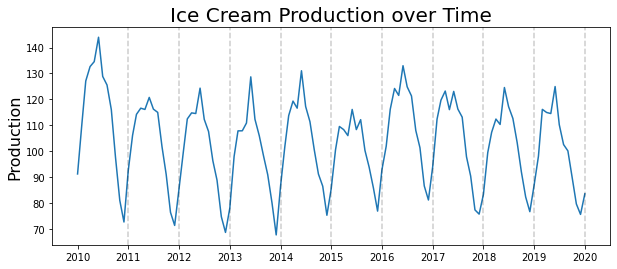

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(df_ice_cream.production)
plt.title("Ice Cream Production over Time", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(2011, 2021):
    plt.axvline(
        pd.to_datetime(str(year) + "-01-01"), color="k", linestyle="--", alpha=0.2
    )

# ACF

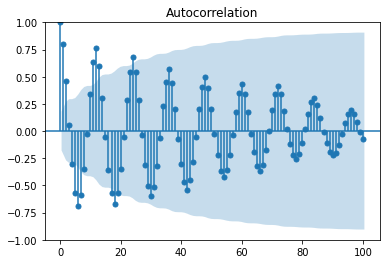

In [21]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

# PACF

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


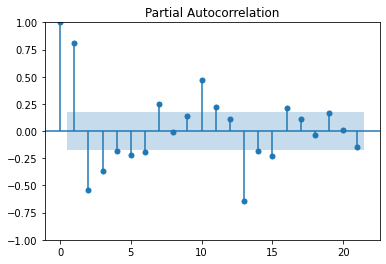

In [22]:
pacf_plot = plot_pacf(df_ice_cream.production)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3, 10, 13

In [44]:
df_ice_cream

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


In [45]:
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = df_ice_cream[:train_end]
test_data = df_ice_cream[train_end + timedelta(days=1) : test_end]

In [46]:
train_data.shape, test_data.shape

((108, 1), (12, 1))

In [49]:
train_data.index = pd.DatetimeIndex(
    train_data.index.values, freq=train_data.index.inferred_freq
)
test_data.index = pd.DatetimeIndex(
    test_data.index.values, freq=test_data.index.inferred_freq
)

In [50]:
# define model. Lag 3 model
model = ARIMA(train_data, order=(3, 0, 0))

In [51]:
# fit the model
start = time()
model_fit = model.fit()
end = time()
print("Model Fitting Time:", end - start)

Model Fitting Time: 0.06539058685302734


In [52]:
# summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Tue, 25 Oct 2022   AIC                            758.170
Time:                        13:34:26   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

### Lag 1 and Lag 3 are important because of their p-value

In [53]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [64]:
# get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data["production"] - predictions

In [66]:
residuals

2019-01-01     5.762551
2019-02-01     7.971090
2019-03-01    14.648628
2019-04-01     3.806251
2019-05-01    -2.499282
2019-06-01     6.834654
2019-07-01    -4.770283
2019-08-01    -6.747015
2019-09-01    -2.967977
2019-10-01    -8.016412
2019-11-01   -15.894087
2019-12-01   -19.990337
Freq: MS, dtype: float64

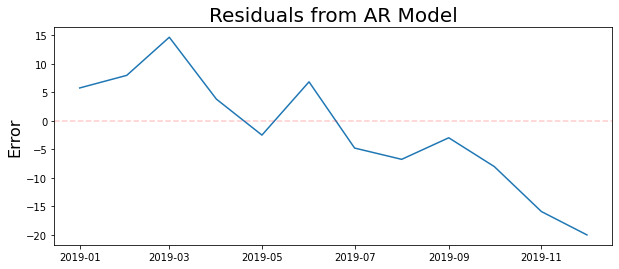

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from AR Model", fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.axhline(0, color="r", linestyle="--", alpha=0.2)

Text(0, 0.5, 'Sales')

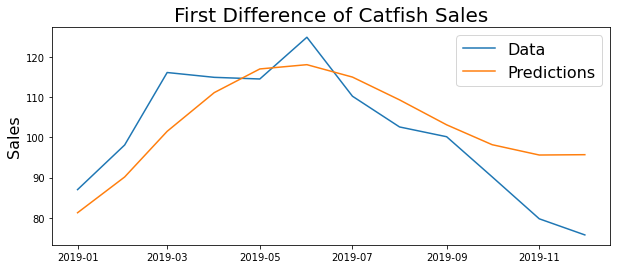

In [68]:
plt.figure(figsize=(10, 4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(("Data", "Predictions"), fontsize=16)

plt.title("First Difference of Catfish Sales", fontsize=20)
plt.ylabel("Sales", fontsize=16)

In [69]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158749392308


In [71]:
print(
    "Mean Absolute Percent Error:",
    round(np.mean(abs(residuals / test_data["production"])), 4),
)

Mean Absolute Percent Error: 0.0895
